In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from copy import deepcopy

# ✅ 데이터 경로 설정
data_dir = "C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\class\\"


def is_valid_file(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception as e:
        print(f"⚠️ 손상되었거나 유효하지 않은 이미지 파일을 건너뜁니다: {path} - {e}")
        return False


# --- 변환(Transform) 두 종류로 정의 ---
# 1. 학습용 변환 (데이터 증강 포함)
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 2. 검증용 변환 (데이터 증강 없음)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# ------------------------------------

# --- 데이터셋을 학습용과 검증용으로 분리 ---
# 1. 전체 데이터셋을 불러옵니다.
full_dataset = datasets.ImageFolder(root=data_dir, is_valid_file=is_valid_file)

# 2. 학습용과 검증용으로 8:2 비율로 나눕니다.
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 3. 각 데이터셋에 맞는 변환(transform)을 적용합니다.
#    (중요: deepcopy를 사용하여 각 데이터셋이 독립적인 변환을 갖도록 함)
train_dataset = deepcopy(train_dataset)
train_dataset.dataset.transform = transform_train

val_dataset = deepcopy(val_dataset)
val_dataset.dataset.transform = transform_val
# -----------------------------------------

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 및 데이터 개수 확인
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"✅ 클래스 목록: {class_names}")
print(f"✅ 총 이미지 수: {len(full_dataset)}")
print(f"✅ 학습 데이터 수: {len(train_dataset)}")
print(f"✅ 검증 데이터 수: {len(val_dataset)}")

⚠️ 손상되었거나 유효하지 않은 이미지 파일을 건너뜁니다: C:\Users\it\Documents\Python-workspace\Ai-ML-DL-workspace-0930\memo\3-Resnet\test\class\책상_images\책상_72.jpg - cannot identify image file 'C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\class\\책상_images\\책상_72.jpg'
✅ 클래스 목록: ['의자_images', '책상_images']
✅ 총 이미지 수: 493
✅ 학습 데이터 수: 394
✅ 검증 데이터 수: 99


In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 데이터 폴더 경로 설정
data_dir = "C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\class\\"

# 폴더 안에 있는 클래스 확인
print("🔍 데이터셋 폴더 내 클래스 확인:")
print(os.listdir(data_dir))

🔍 데이터셋 폴더 내 클래스 확인:
['의자_images', '책상_images']


In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# ✅ ResNet-50 모델 불러오기 (사전 학습된 모델 사용)
model = models.resnet50(pretrained=True)

# ✅ 마지막 Fully Connected Layer 변경 (기존 1000 → 데이터셋 클래스 개수)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ✅ 모델을 GPU로 이동 (가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 최적화 함수 및 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import copy  # 모델의 state_dict를 복사하기 위해 import

num_epochs = 15  # 학습 횟수를 15~20회로 늘려 최고점을 찾을 기회를 더 줍니다.
best_val_accuracy = 0.0  # 최고 검증 정확도를 저장할 변수
best_model_wts = None  # 최고 성능일 때의 모델 가중치를 저장할 변수

print("🚀 모델 학습 시작...")

for epoch in range(num_epochs):
    # --- 학습 단계 ---
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 5 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Train Loss: {running_loss / 5:.4f}")
            running_loss = 0.0

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"\nEpoch [{epoch + 1}/{num_epochs}] COMPLETE")
    print(f"Validation Loss: {val_loss / len(val_loader):.4f} | Validation Accuracy: {val_accuracy:.2f} %")

    # --- 최고 성능 모델 저장 ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())  # 현재 모델의 가중치를 복사하여 저장
        print(f"🎉 최고 정확도 경신: {best_val_accuracy:.2f} %! 모델을 저장합니다.")
    print("-" * 30)

# --- 학습 종료 후 최고 성능 모델 저장 ---
if best_model_wts:
    model.load_state_dict(best_model_wts)  # 가장 성능이 좋았던 가중치로 모델을 복원
    model_path = "C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\best_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"\n✅ 최종 최고 성능 모델 저장 완료!")
    print(f"   - 경로: {model_path}")
    print(f"   - 최고 검증 정확도: {best_val_accuracy:.2f} %")

🚀 모델 학습 시작...


C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/15], Step [5/13], Train Loss: 0.8160
Epoch [1/15], Step [10/13], Train Loss: 0.7151

Epoch [1/15] COMPLETE
Validation Loss: 475.4897 | Validation Accuracy: 66.67 %
🎉 최고 정확도 경신: 66.67 %! 모델을 저장합니다.
------------------------------
Epoch [2/15], Step [5/13], Train Loss: 0.5955
Epoch [2/15], Step [10/13], Train Loss: 0.5815

Epoch [2/15] COMPLETE
Validation Loss: 2.2907 | Validation Accuracy: 64.65 %
------------------------------
Epoch [3/15], Step [5/13], Train Loss: 0.5778
Epoch [3/15], Step [10/13], Train Loss: 0.5853

Epoch [3/15] COMPLETE
Validation Loss: 0.5754 | Validation Accuracy: 74.75 %
🎉 최고 정확도 경신: 74.75 %! 모델을 저장합니다.
------------------------------
Epoch [4/15], Step [5/13], Train Loss: 0.4705
Epoch [4/15], Step [10/13], Train Loss: 0.4502

Epoch [4/15] COMPLETE
Validation Loss: 0.8402 | Validation Accuracy: 77.78 %
🎉 최고 정확도 경신: 77.78 %! 모델을 저장합니다.
------------------------------
Epoch [5/15], Step [5/13], Train Loss: 0.4276
Epoch [5/15], Step [10/13], Train Loss: 0.431

In [5]:
model_path = "C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\resnet50-251010_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ 학습된 모델이 저장되었습니다: {model_path}")



✅ 학습된 모델이 저장되었습니다: C:\Users\it\Documents\Python-workspace\Ai-ML-DL-workspace-0930\memo\3-Resnet\test\resnet50-251010_model.pth


In [6]:

def load_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)  # 새 모델 생성
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Fully Connected Layer 맞춤 설정
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))  # CPU에서 로드
    model.eval()  # 평가 모드로 설정
    return model


# ✅ 모델 불러오기
loaded_model = load_model(model_path, num_classes)
print("✅ 모델이 성공적으로 불러와졌습니다!")

C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ 모델이 성공적으로 불러와졌습니다!


C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52293 (\N{HANGUL SYLLABLE CAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\it\anaconda3\envs\Pytorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


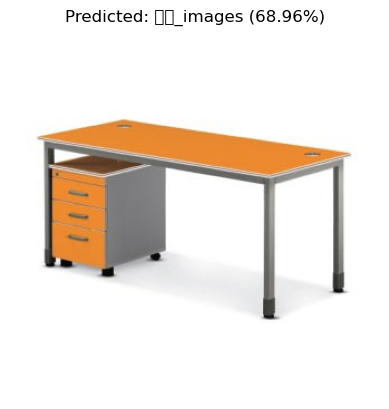

🔍 예측된 클래스: 책상_images
📊 정확도: 68.96%


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F


def predict_sample(image_path, model, class_names):
    """
       저장된 ResNet-50 모델을 사용하여 샘플 이미지를 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet 정규화 값
    ])
    image = transform(image).unsqueeze(0)  # 배치 차원 추가 (1, 3, 224, 224)

    # 모델 예측
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output[0], dim=0)  # Softmax 적용
        predicted_idx = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_idx].item()

    # ✅ 결과 출력
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {class_names[predicted_idx]} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"🔍 예측된 클래스: {class_names[predicted_idx]}")
    print(f"📊 정확도: {confidence * 100:.2f}%")


# 🏆 샘플 이미지 경로 입력하여 예측 실행
sample_image = "C:\\Users\\it\\Documents\\Python-workspace\\Ai-ML-DL-workspace-0930\\memo\\3-Resnet\\test\\sample1.png"
predict_sample(sample_image, loaded_model, class_names)
